# TESS planet candidate vetting I

In this notebook, we study the table of currently known TOIs downloaded from [ExoFOP](https://exofop.ipac.caltech.edu/tess/view_toi.php) and download a sample of confirmed planets (CPs) and false positives (FPs) for OpenTS analysis.

In [1]:
%matplotlib inline

In [131]:
import warnings
import shutil
import pandas as pd
import lightkurve as lk

from pathlib import Path
from matplotlib.pyplot import subplots, setp
from tqdm.auto import tqdm

In [4]:
tois = pd.read_csv('exofop_toilists.csv')
confirmed_planets = tois[tois['TFOPWG Disposition'] == 'CP']
false_positives = tois[tois['TFOPWG Disposition'] == 'FP']

In [53]:
def plot_hist(cname, range, bins=20):
    fig, axs = subplots(1, 2, figsize=(13,4), sharey='all')
    confirmed_planets[cname].hist(range=range, density=True, bins=bins, ax=axs[0])
    false_positives[cname].hist(range=range, density=True, bins=bins, ax=axs[1])
    setp(axs, xlabel=cname, yticks=[])
    axs[0].set_title('Confirmed planets')
    axs[1].set_title('False positives')
    fig.tight_layout()
    return fig

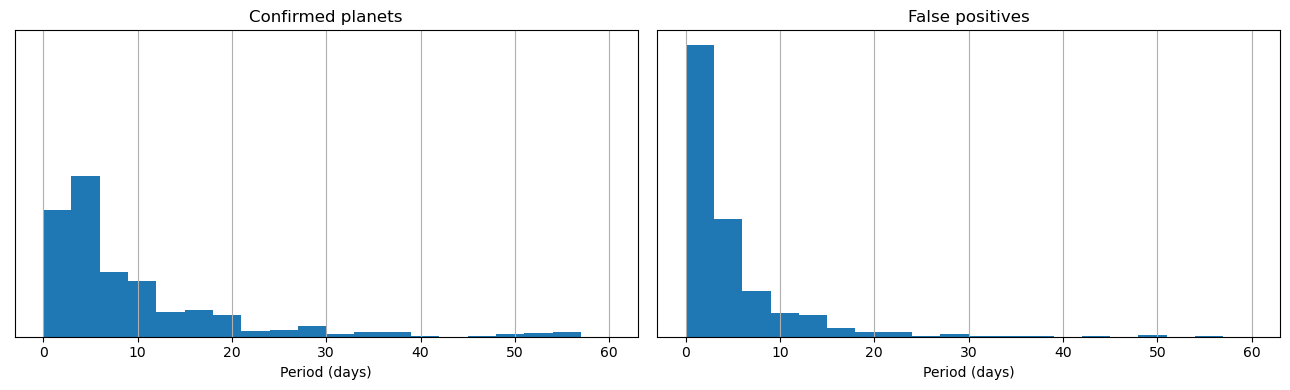

In [54]:
plot_hist('Period (days)', (0, 60));

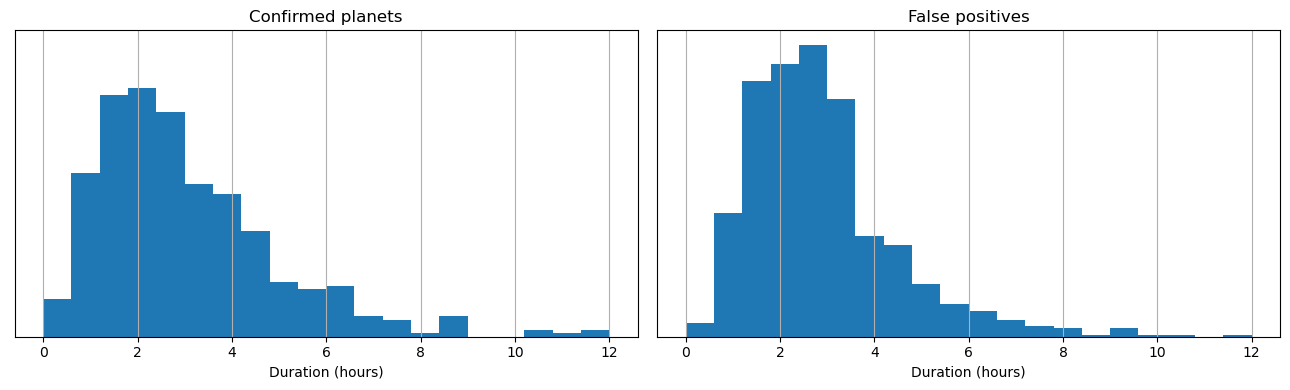

In [55]:
plot_hist('Duration (hours)', (0, 12));

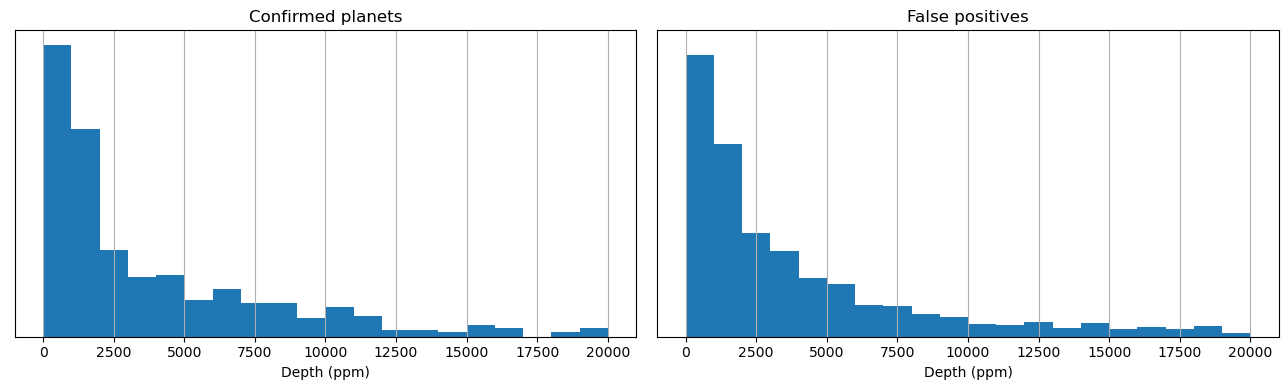

In [56]:
plot_hist('Depth (ppm)', (0, 20_000));

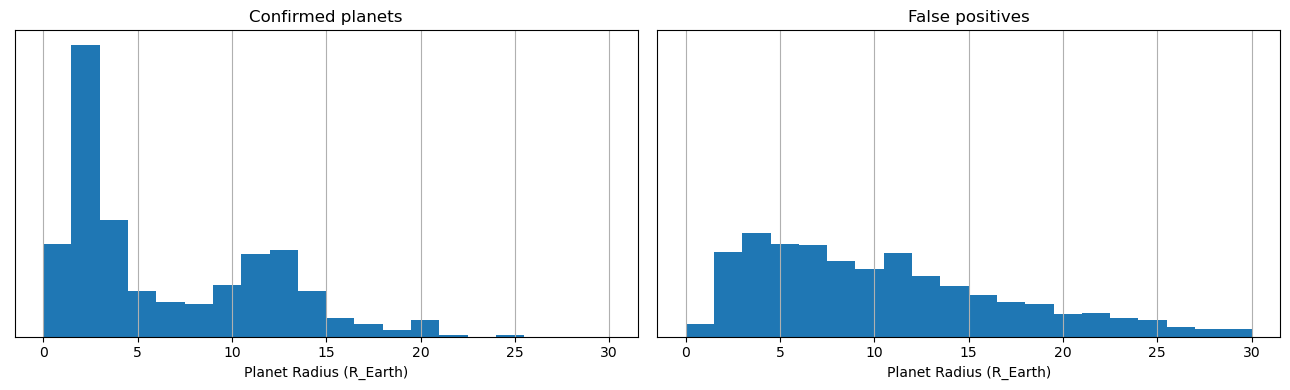

In [57]:
plot_hist('Planet Radius (R_Earth)', (0, 30));

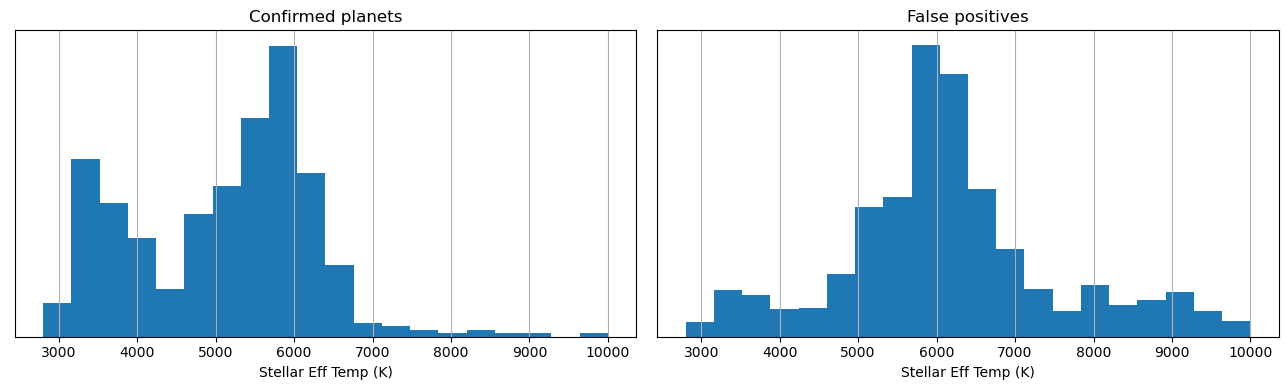

In [62]:
plot_hist('Stellar Eff Temp (K)', (2800, 10000));

## Create CP and FP samples and download the light curves

In [167]:
ns = 100
cpm = confirmed_planets['Period (days)'] <= 10
cp_sample = confirmed_planets[cpm].sample(2*ns, random_state=0)

fpm = false_positives['Period (days)'] <= 10
fp_sample = false_positives[fpm].sample(2*ns, random_state=0)

In [172]:
cp_final = []
n_good = 0
pb = tqdm(total=ns)
for _, toi in cp_sample.iterrows():
    lcs = lk.search_lightcurve(f'TIC {toi["TIC ID"]}', mission='TESS', author='SPOC', exptime='short')
    if len(lcs) > 0:
        cp_final.append(lcs)
        n_good += 1
        pb.update()
    if n_good == ns:
        pb.close()
        break

  0%|          | 0/100 [00:00<?, ?it/s]

In [177]:
for cs in tqdm(cp_final):
    cs[:3].download_all(download_dir='data/cp')

In [176]:
fp_final = []
n_good = 0
pb = tqdm(total=ns)
for _, toi in fp_sample.iterrows():
    lcs = lk.search_lightcurve(f'TIC {toi["TIC ID"]}', mission='TESS', author='SPOC', exptime='short')
    if len(lcs) > 0:
        fp_final.append(lcs)
        n_good += 1
        pb.update()
    if n_good == ns:
        pb.close()
        break

  0%|          | 0/100 [00:00<?, ?it/s]

In [178]:
for fs in tqdm(fp_final):
    fs[:3].download_all(download_dir='data/fp')

## Copy the light curves into cp and cp directories

In [179]:
cpfiles = sorted(Path('data/cp').glob('**/*.fits'))

for f in cpfiles:
    try:
        shutil.copy2(f, Path(f'data/cp/files/{f.name}'))
    except shutil.SameFileError:
        pass

In [180]:
fpfiles = sorted(Path('data/fp').glob('**/*.fits'))

for f in fpfiles:
    try:
        shutil.copy2(f, Path(f'data/fp/files/{f.name}'))
    except shutil.SameFileError:
        pass